In [54]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

In [55]:
batch_size = 64

data_dir = os.path.join('/mnt', 'disks', 'disk-1', 'data')
csv_dir = os.path.join('data', 'CSVs')
models_dir = os.path.join(data_dir, 'models')
csv_path = {
    'train': os.path.join(csv_dir, 'tiles_train.csv'),
    'validation': os.path.join(csv_dir, 'tiles_validation.csv'),
    'test': os.path.join(csv_dir, 'tiles_test.csv'),
}

img_path = os.path.join(data_dir,
                        'tiles')

img_path_test = os.path.join(data_dir,
                        'tiles', 'tiles')
image_classes = ['cored', 'diffuse', 'CAA']

In [56]:
test = pd.read_csv(os.path.join(csv_dir, 'test_multilabel.csv'))

In [57]:
np.random.seed(42)
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
src_test = (ImageList.from_df(path=img_path_test, df=test, folder='hold-out')
       .split_none()
       .label_from_df(label_delim=' '))

In [58]:
data_test = (src_test.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))
resnet34 = models.resnet34
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data_test, resnet34, metrics=[acc_05, f_score])

In [80]:
model_name = 'stage-1-rn34-v3'

In [81]:
learn = learn.load(os.path.join(models_dir, model_name))

In [82]:
learn.data.valid_dl = data_test.train_dl
learn.validate(metrics=[acc_05, f_score])

[0.06344032, tensor(0.9788), tensor(0.9692)]

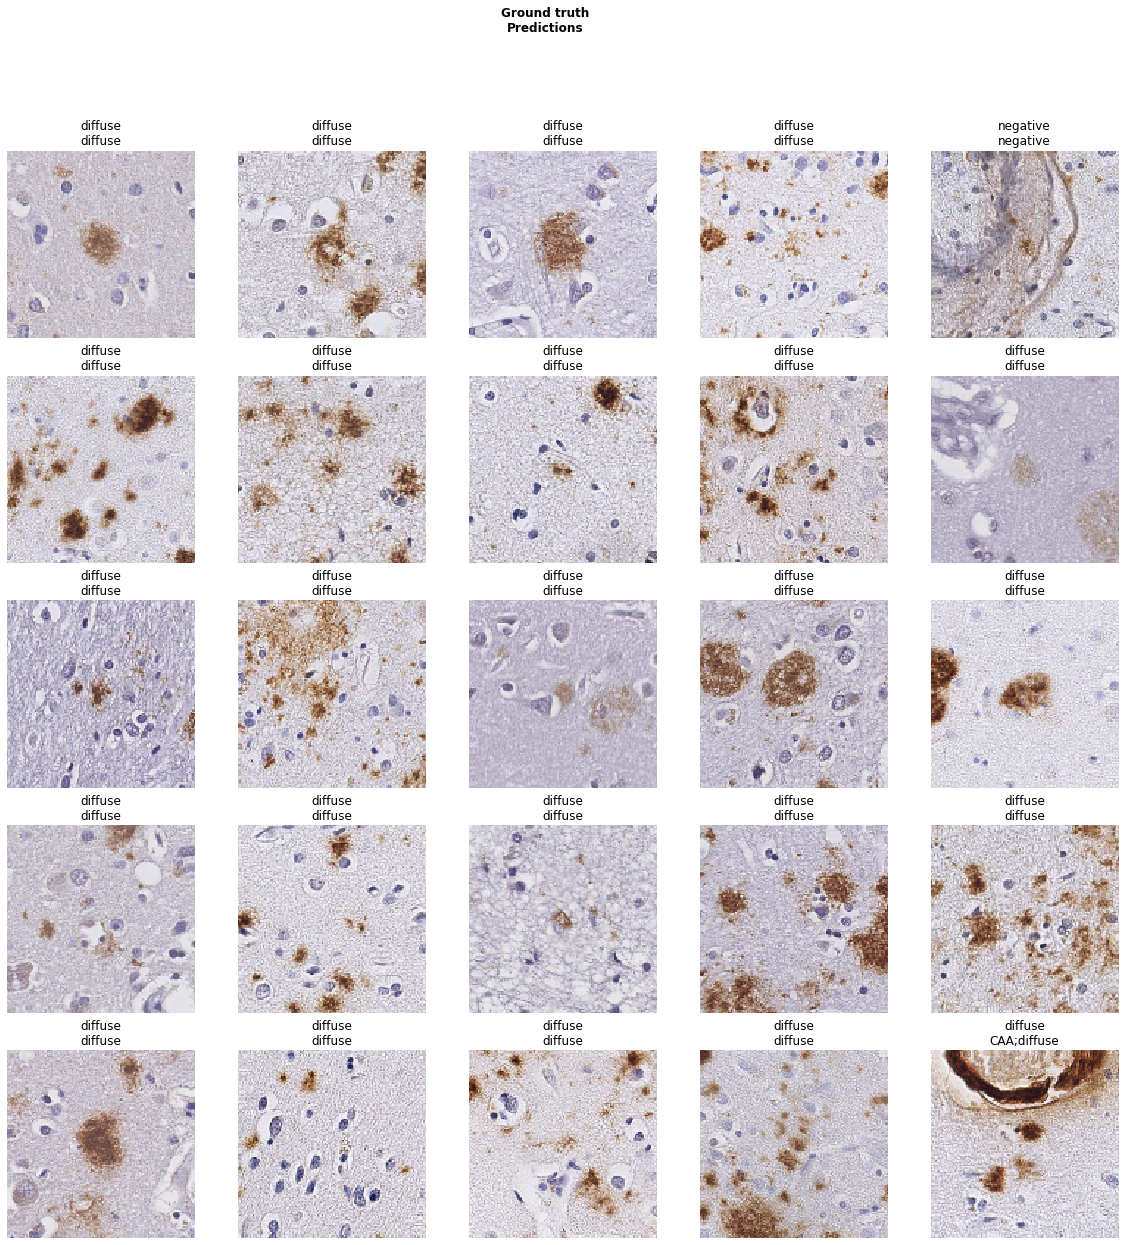

In [83]:
learn.show_results()

In [84]:
preds, y = learn.get_preds()

In [85]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    fig = plt.figure(figsize=(1.2*size, size))
    ax = plt.axes()
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(label[:,i].ravel(), preds[:,i].ravel())
        lw = 0.2*size
        # Plot all ROC curves
        ax.plot([0, 1], [0, 1], 'k--', lw=lw, label='random')
        ax.plot(fpr, tpr,
                 label='ROC-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(fpr, tpr)),
                  color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)
       
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=1.8*size)
    ax.set_ylabel('True Positive Rate', fontsize=1.8*size)
    ax.set_title('Receiver operating characteristic Curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc=0, fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

    
def plot_prc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    
    fig = plt.figure(figsize=(1.2*size,size))
    ax = plt.axes()
    
    for i in range(preds.shape[1]):
        rp = (label[:,i]>0).sum()/len(label)
        precision, recall, _ = precision_recall_curve(label[:,i].ravel(), preds[:,i].ravel())
        
        lw=0.2*size
    
        ax.plot(recall, precision,
                 label='PR-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(recall, precision)),
                 color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)

        ax.plot([0, 1], [rp, rp], 'k--', color=colors[(i+preds.shape[1])%len(colors)], lw=lw, label='random')
   
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=1.8*size)
    ax.set_ylabel('Precision', fontsize=1.8*size)
    ax.set_title('Precision-Recall curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc="lower left", bbox_to_anchor=(0.01, 0.1), fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

saved
saved


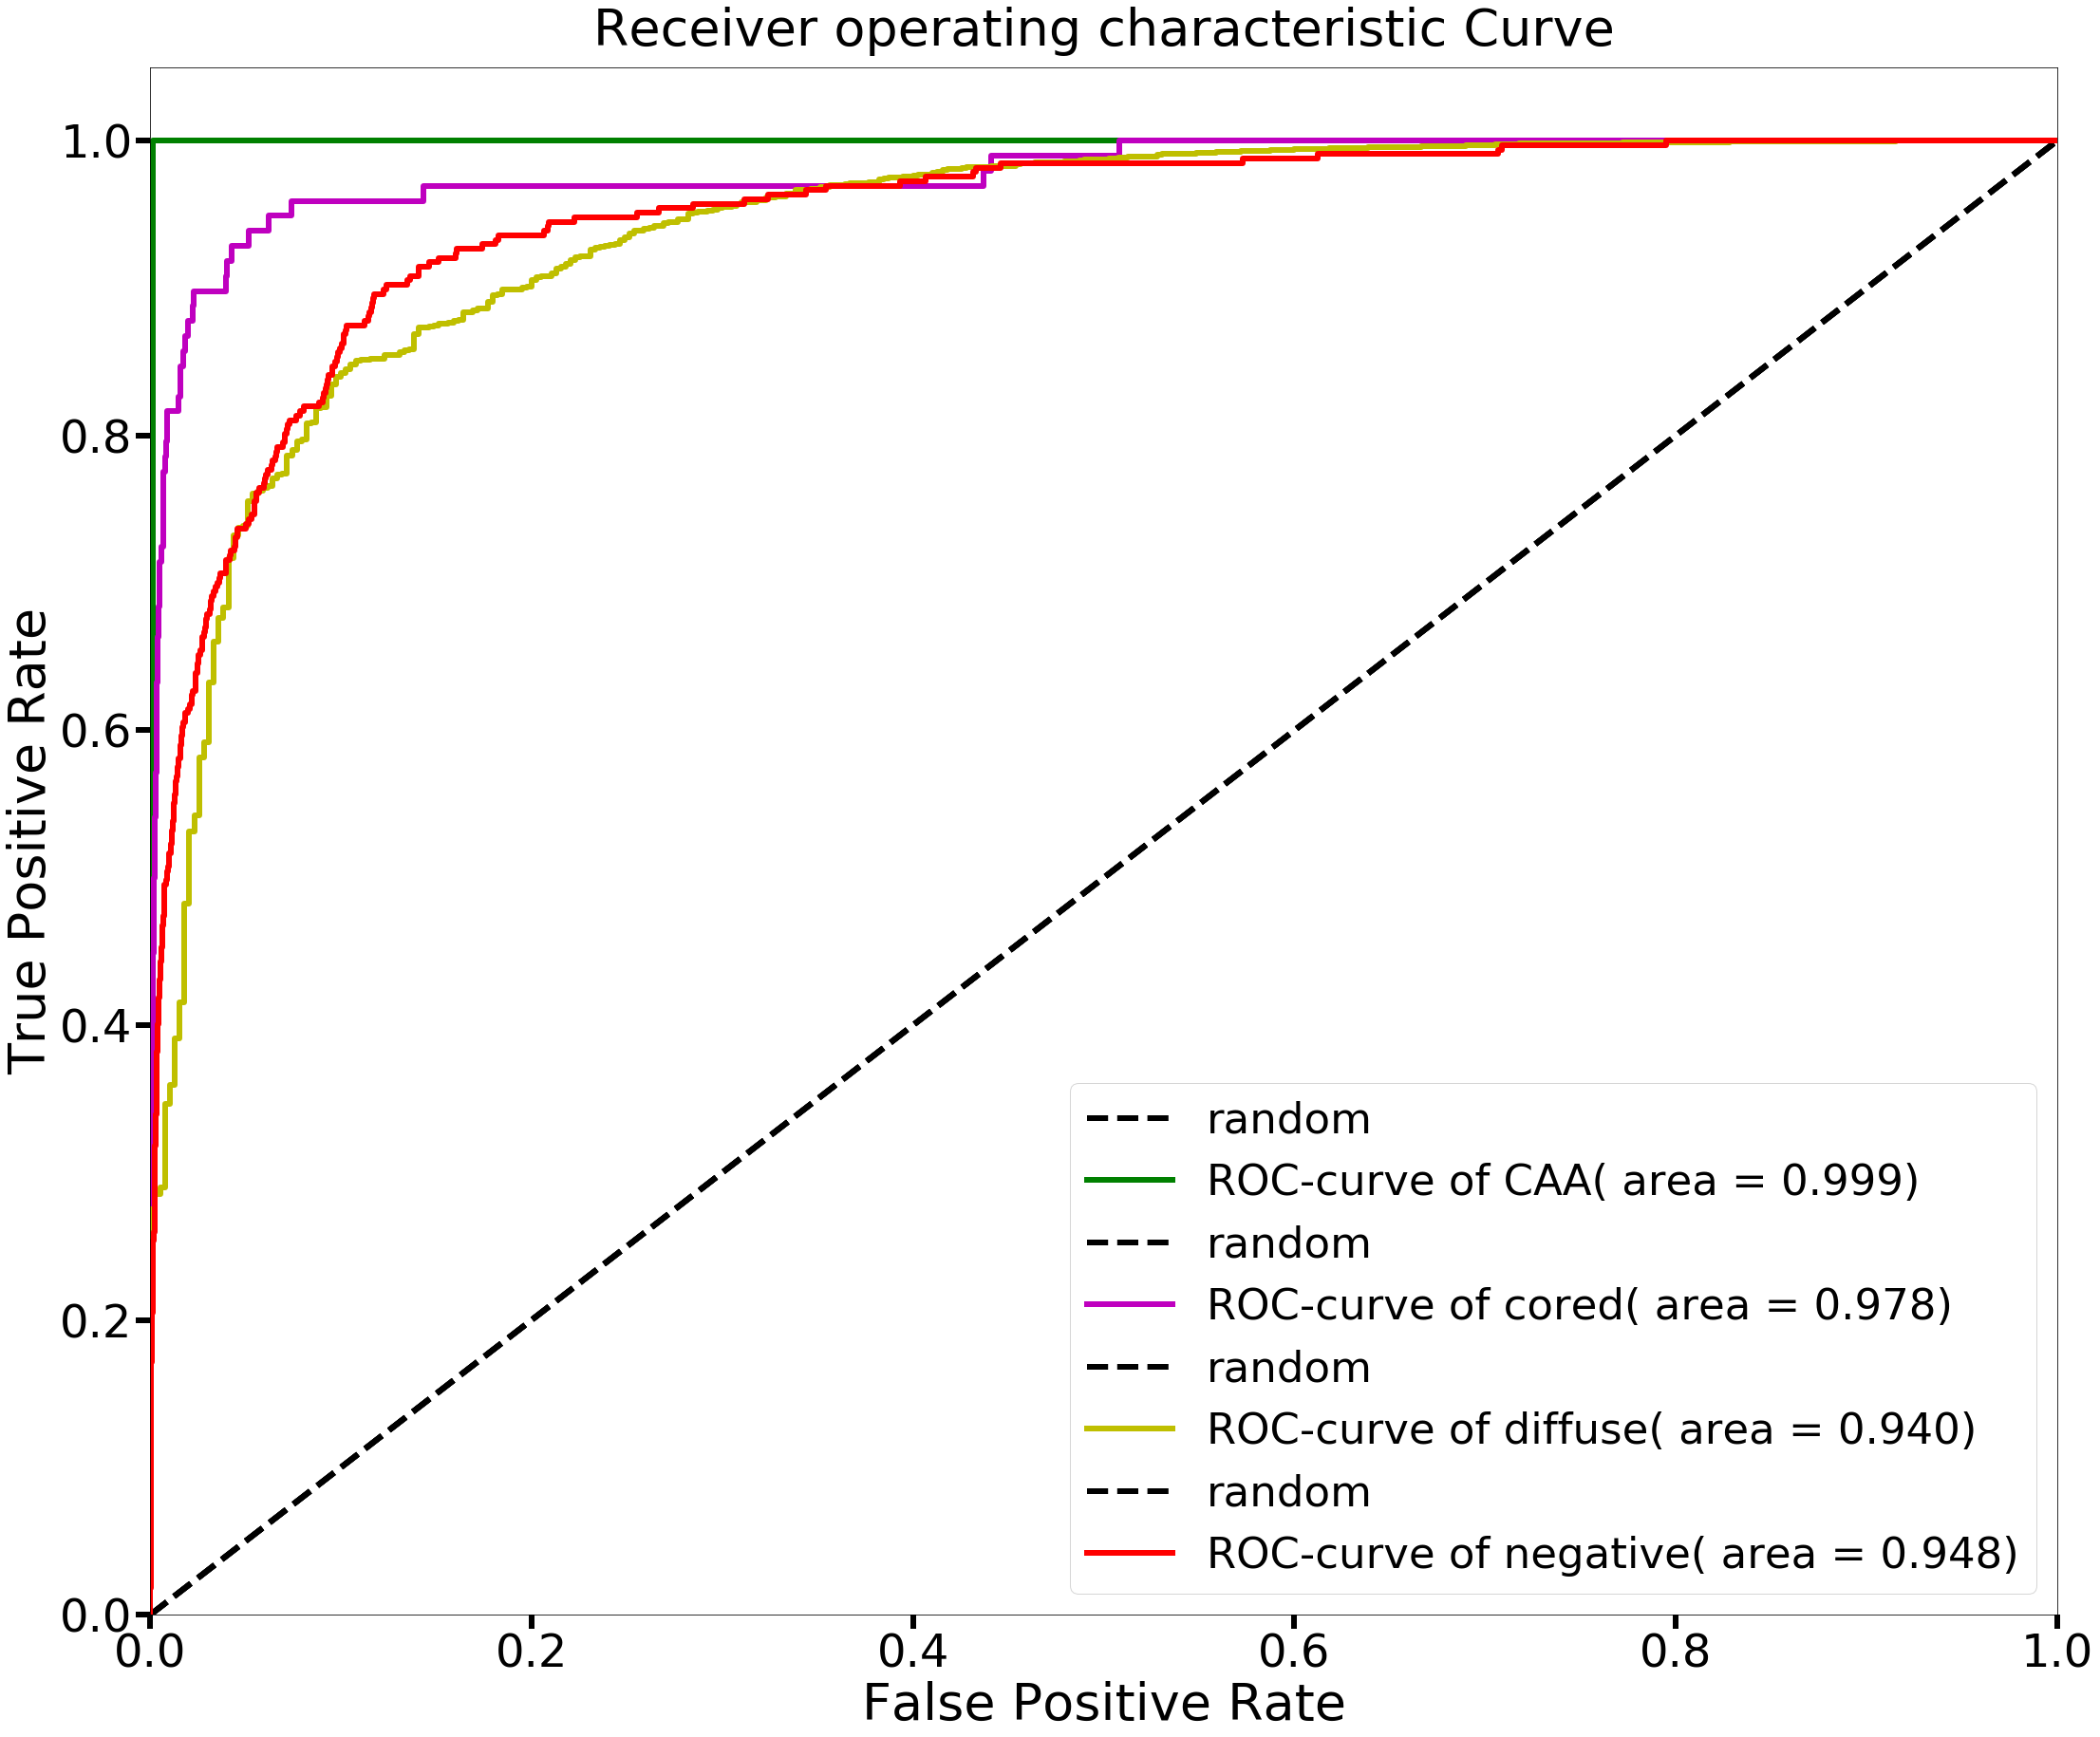

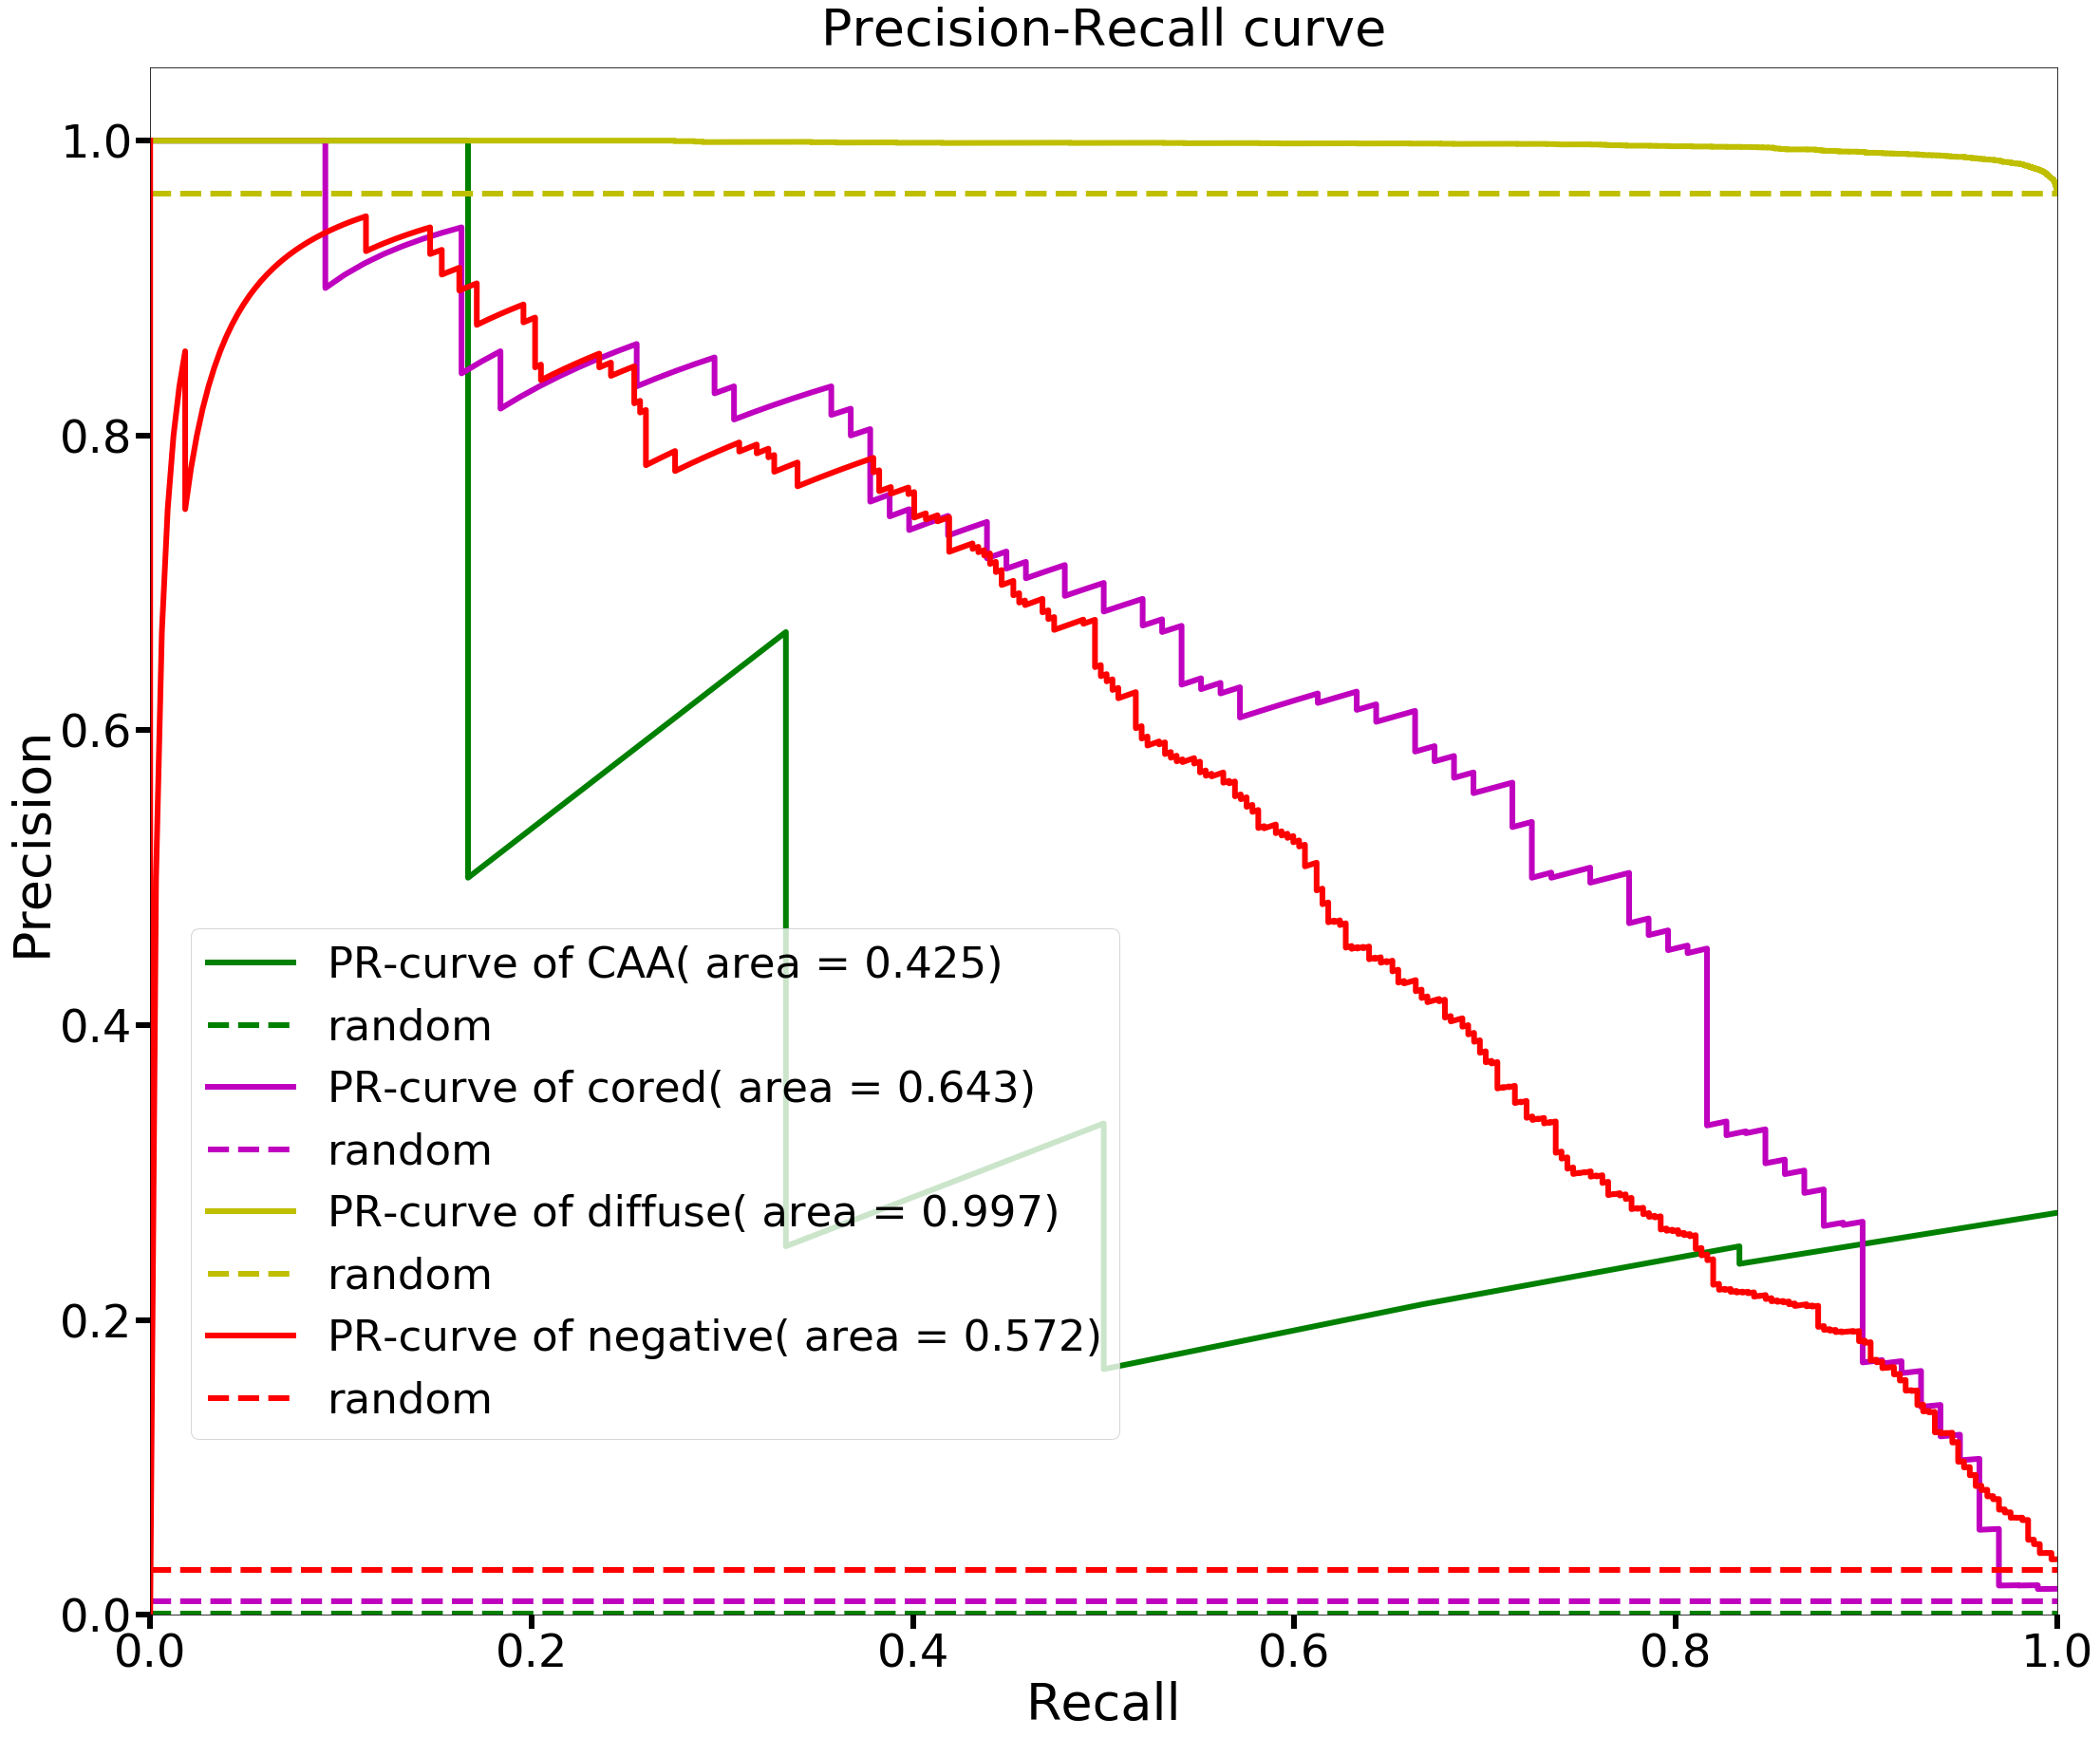

In [86]:
plot_roc(preds.numpy(), y.numpy(), learn.data.classes, size=30,
         path=os.path.join(models_dir, f'{model_name}_roc_plot.png'))
plot_prc(preds.numpy(), y.numpy(), learn.data.classes, size=30,
         path=os.path.join(models_dir, f'{model_name}_prc_plot.png'))

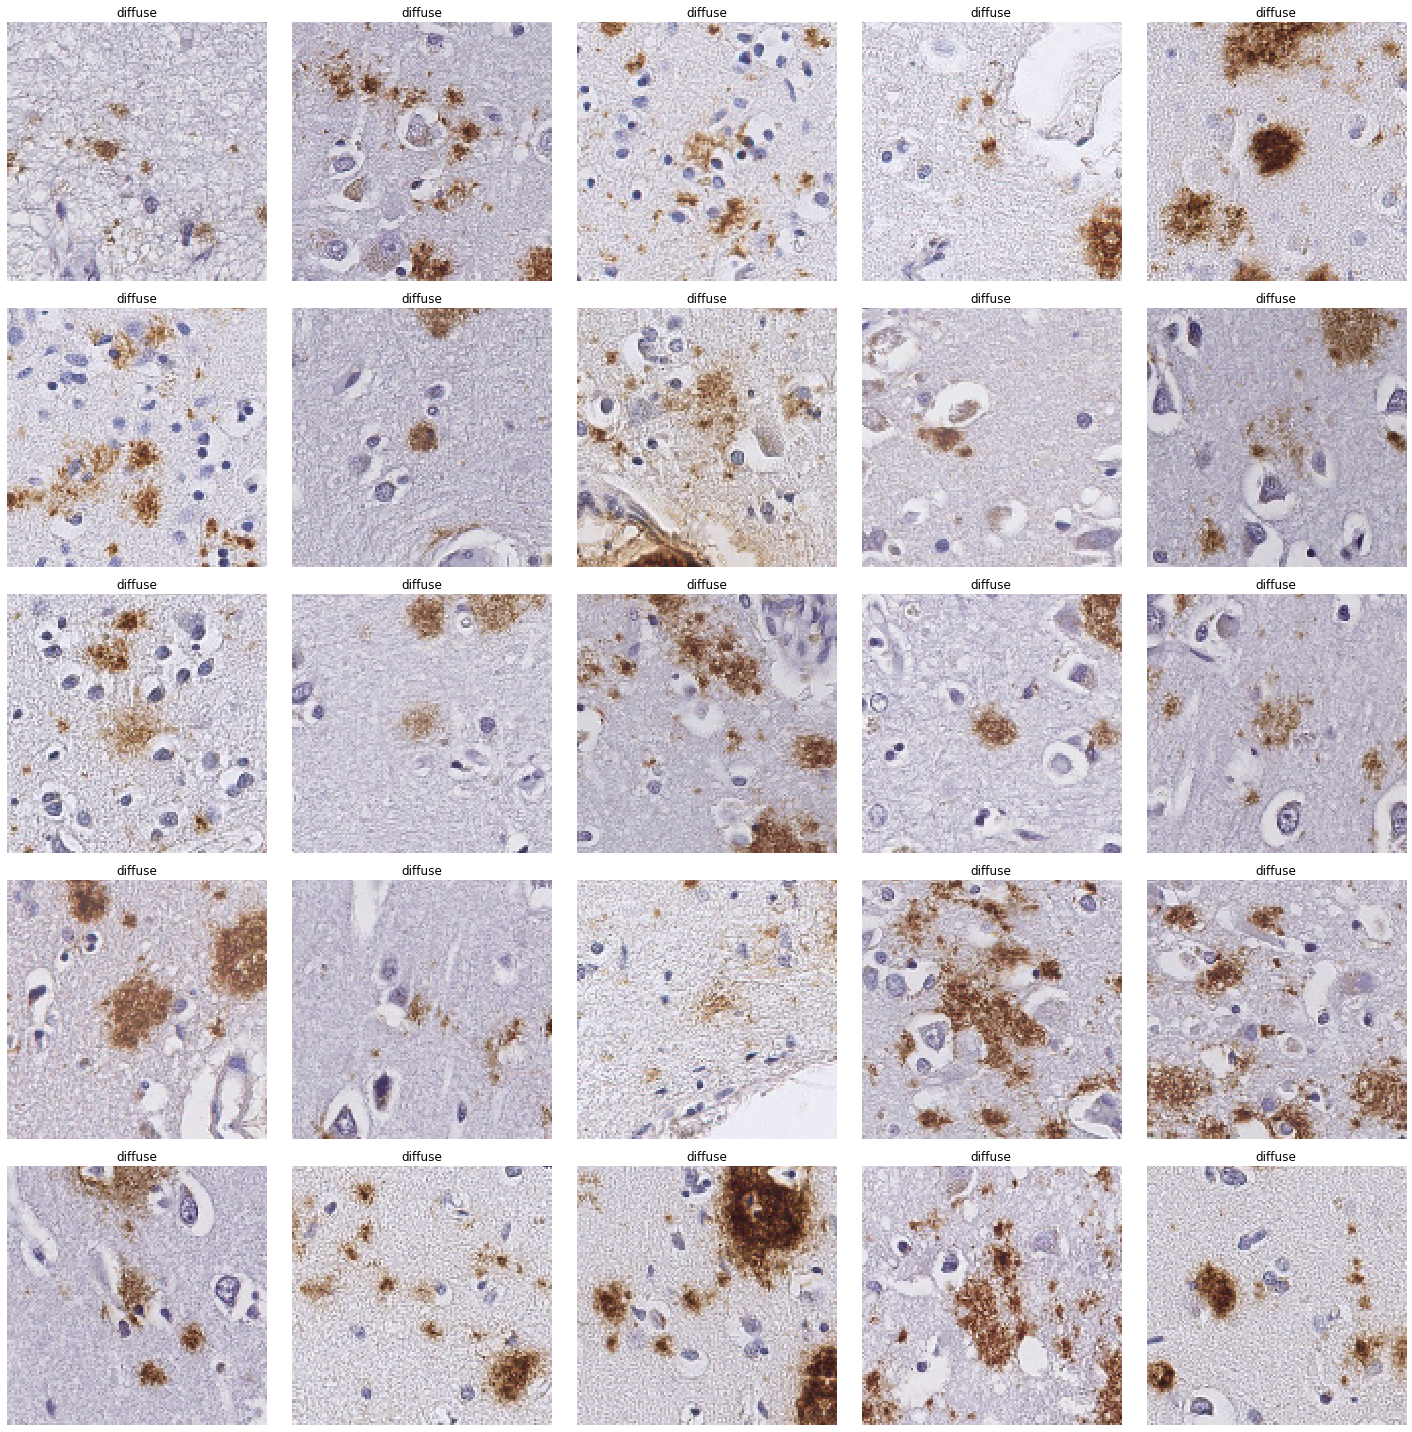

In [26]:
data_test.show_batch()